<a href="https://colab.research.google.com/github/rrsguim/PhD_Economics/blob/master/RIDE_FNN_v2_YoY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------------------------------------
Copyright (c) 2021 Rafael Guimaraes

See full material at https://github.com/rrsguim/RIDE

The code below is under the Apache License

-------------------------------------------------------------------------

#RIDE - Representation learning for Interpolation, Distribution and Extrapolation of time series by related series

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
!pip install -U keras-tuner

In [4]:
import os
import datetime
import tempfile

import IPython
import IPython.display

import tensorflow as tf
from tensorflow import keras

import kerastuner as kt
from kerastuner import RandomSearch

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
mpl.rcParams['axes.grid'] = False
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  # This is added back by InteractiveShellApp.init_path()


## The dataset

O arquivo csv para entrada de dados deve conter a data na primeira coluna, o Target (a série de tempo a ser transformada) na segunda coluna e as series relacionadas nas demais colunas.

In [5]:
file = tf.keras.utils
raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/RIDE/main/RIDE_BR_GDP_data_long.csv') 
#raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/RIDE/main/RIDE_BR_GDP_data_wide.csv') 

In [6]:
#raw_data.index = raw_data['DATE']

In [7]:
#date_time = pd.to_datetime(raw_data.pop('DATE'), infer_datetime_format=True)

Let's take a glance at the data. Here are the first few rows:

In [8]:
raw_data.pop('DATE')

0      1/1/1996
1      2/1/1996
2      3/1/1996
3      4/1/1996
4      5/1/1996
         ...   
289    2/1/2020
290    3/1/2020
291    4/1/2020
292    5/1/2020
293    6/1/2020
Name: DATE, Length: 294, dtype: object

In [9]:
raw_data.head() ## just checking here

,TARGET,epeRes,epeCom,epeInd,expQ,impQ,expBasic,expSemi,expManuf,expAgroDolar,anfaveaProd,anfaveaLic,cagedTransf,cagedConstr,cagedCom,cagedServ,ipa,cambio,poup,m1,m2,ibov,embi,RecRFBIPCA
0,96.839684,5851,2951,8753,34.46,52.16,22.82,53.76,33.56,115.9140,100946,105226,5982.422,2015.581,4730.099,10299.511,100.000000,0.9786,64902724,23481820.0,175037084.0,48309.00000,760,42102.33310
1,96.839684,5742,3007,9278,33.81,51.17,21.56,45.53,36.25,109.4380,121248,123172,5951.516,2017.003,4720.066,10308.072,100.030000,0.9842,65233099,23095259.0,174828178.0,52663.10526,863,38945.85196
2,96.839684,5845,2956,9204,34.02,59.07,21.92,42.55,36.26,180.2097,136019,140737,5922.355,2020.226,4710.568,10306.570,99.879955,0.9880,65267819,22985492.0,175383395.0,49296.71429,840,54428.61606
3,100.119467,5876,3041,9539,42.08,61.83,37.31,55.51,39.86,379.7159,130698,136759,5934.785,2030.111,4716.401,10331.354,100.249511,0.9925,65114540,23276407.0,173647972.0,50170.85000,763,41601.87886
4,100.119467,5676,2885,9623,44.35,64.43,38.06,58.86,42.23,329.6451,142309,151333,5970.066,2037.631,4727.189,10350.637,100.480085,0.9984,64692969,22761723.0,172226628.0,54828.00000,748,42501.10547


fill target data (before) 

In [10]:
raw_data.iloc[:,0].fillna(method='bfill', inplace=True) # If not filled, each month in the quarter will have the same value for the target "fbcf", following Friedman ...

year over year percentage change

In [11]:
raw_data = raw_data.pct_change(12)

In [12]:
raw_data = raw_data.iloc[12:] ## delete first 12 observation (NaN)

In [13]:
raw_data.head() ## checking again

,TARGET,epeRes,epeCom,epeInd,expQ,impQ,expBasic,expSemi,expManuf,expAgroDolar,anfaveaProd,anfaveaLic,cagedTransf,cagedConstr,cagedCom,cagedServ,ipa,cambio,poup,m1,m2,ibov,embi,RecRFBIPCA
12,0.034006,0.114681,0.121315,0.080201,0.087638,-0.229103,0.148992,0.144903,0.093266,0.826288,0.237186,0.281299,-0.021838,-0.004758,-0.002582,-0.003920,0.040466,0.068976,0.188399,0.410615,0.081338,0.573667,-0.425000,0.086017
13,0.034006,0.075583,0.070502,0.060573,-0.073943,0.321282,-0.078386,-0.105645,-0.069517,1.084577,0.124332,0.186195,-0.017162,-0.004872,-0.001402,-0.004143,0.043794,0.068380,0.206624,0.569019,0.103404,0.641136,-0.514484,0.119599
14,0.034006,0.025321,0.055819,0.030856,0.111699,0.285763,0.499544,0.037838,0.025372,1.483364,0.126049,0.201845,-0.011839,-0.001835,0.002776,-0.001437,0.046930,0.072166,0.226244,0.629228,0.116062,-0.812543,-0.441667,-0.111716
15,0.047540,0.029612,0.030582,0.042562,0.076759,0.415818,0.265612,0.019456,-0.003763,1.032106,0.319003,0.344438,-0.010250,0.000405,0.004838,-0.001567,0.047243,0.071839,0.242170,0.559438,0.127847,-0.808730,-0.401048,0.194679
16,0.047540,0.067477,0.074523,0.070768,0.021646,0.214496,0.279559,-0.124193,-0.060620,1.413065,0.140546,0.158042,-0.009671,0.000121,0.007182,-0.001187,0.046512,0.073417,0.264305,0.619418,0.151070,-0.806706,-0.459893,0.070950


Check the evolution of the target over time. 

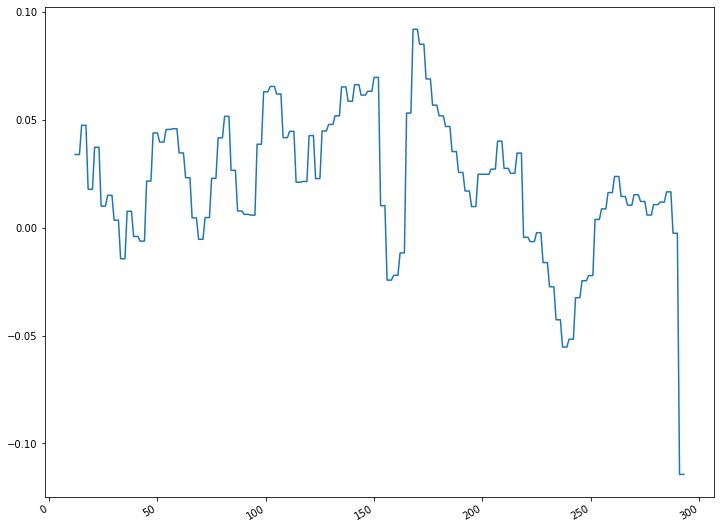

In [14]:
plot_target = raw_data.iloc[:,0]
_ = plot_target.plot(subplots=True)

### DON'T convert the data to log-space

In [15]:
raw_data_log = raw_data  #np.log(raw_data) 

### Split and normalize the data

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however, the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data.

It is important to scale features XXXXX Label too, is ti wrong? XXXXX Following Friedman?? XXXXbefore training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [16]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(raw_data_log, test_size=0.2, shuffle=True)  
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True)  

########## if include labels when normalizing
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
##########

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('TARGET')) 
val_labels = np.array(val_df.pop('TARGET'))     
test_labels = np.array(test_df.pop('TARGET'))  

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

don't include labels when normalizing

In [17]:
#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)

#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

## DL Model


#### Define the model and metrics

Define a function that creates a deep neural network with LSTM and densly connected hidden layers, regularizers to reduce overfitting, and an output layer that returns the output gap estimation. Also, pick the optimal set of hyperparameters with [Keras Tunner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [18]:
def make_model(hp):  

  model = keras.Sequential()
  # Tune the number of units in the layers
  # Choose an optimal value between 16-256
  #hp_lstm_units = hp.Int('lstm_units', min_value = 16, max_value = 256, step = 16)
  hp_dense_units = hp.Int('dense_units', min_value = 16, max_value = 256, step = 16)


### LSTM ###
  # Tune the dropout
  # Choose an optimal value from 0.2 to 0.7
  #hp_dropout = hp.Float('dropout', 0.2, 0.7, step=0.1, default=0.5)

  #model.add(keras.layers.LSTM(units = hp_lstm_units, input_shape = (1,train_features.shape[-1],), dropout = hp_dropout))
### LSTM ###


### DENSE ###
  # Tune the lambda for the regularizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_reg_lambda = hp.Choice('reg_lambda', values = [1e-2, 1e-3, 1e-4])

  #Tune the activation function
  hp_activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')

  #LASSO (L1)
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 1
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 2
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 3
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 4

  #Ridge (L2)
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 1
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 2
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 3
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 4 
### DENSE ###


  model.add(keras.layers.Dense(1)) # Output layer


  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])


  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #optimizer = keras.optimizers.Adagrad(learning_rate = hp_learning_rate),
                loss = keras.losses.MeanSquaredError(), 
                metrics = [keras.metrics.MeanAbsoluteError()])
   
  return model

In [19]:
tuner = kt.Hyperband(make_model, 
                     kt.Objective('val_mean_absolute_error', direction='min'), #
                     max_epochs = 50,) #15
                     #factor = 3,)
                     #project_name = 'TL4OG')

#### Train the model

Before running the hyperparameter search, define a callback to clear the training outputs at the end of every training step.

In [20]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.

In [21]:
tuner.search(train_features, train_labels,
             epochs=50,
             validation_data=(val_features, val_labels), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the in the densely-connected
layers is {best_hps.get('dense_units')}, while the activation function is {best_hps.get('dense_activation')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, and the optimal lambda for the regularizer is {best_hps.get('reg_lambda')}.
""")

Trial 90 Complete [00h 00m 05s]
val_mean_absolute_error: 0.19615046679973602

Best val_mean_absolute_error So Far: 0.19268536567687988
Total elapsed time: 00h 02m 40s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the in the densely-connected
layers is 176, while the activation function is tanh, the optimal learning rate for the optimizer
is 0.001, and the optimal lambda for the regularizer is 0.001.



Retrain the model with the optimal hyperparameters from the search.

In [22]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
baseline_history = model.fit(train_features, train_labels,
             epochs=200,
             validation_data=(val_features, val_labels))

Epoch 1/200
6/6 [==============================] - 1s 38ms/step - loss: 6.8858 - mean_absolute_error: 0.5215 - val_loss: 6.7905 - val_mean_absolute_error: 0.4530
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 6.5815 - mean_absolute_error: 0.3889 - val_loss: 6.4700 - val_mean_absolute_error: 0.3363
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 6.4118 - mean_absolute_error: 0.3370 - val_loss: 6.3477 - val_mean_absolute_error: 0.3056
Epoch 4/200
6/6 [==============================] - 0s 8ms/step - loss: 6.2414 - mean_absolute_error: 0.2780 - val_loss: 6.1888 - val_mean_absolute_error: 0.2777
Epoch 5/200
6/6 [==============================] - 0s 11ms/step - loss: 6.1144 - mean_absolute_error: 0.2587 - val_loss: 6.0652 - val_mean_absolute_error: 0.2679
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 5.9707 - mean_absolute_error: 0.2213 - val_loss: 5.9103 - val_mean_absolute_error: 0.2310
Epoch 7/200
6/6 [===============

#### Results

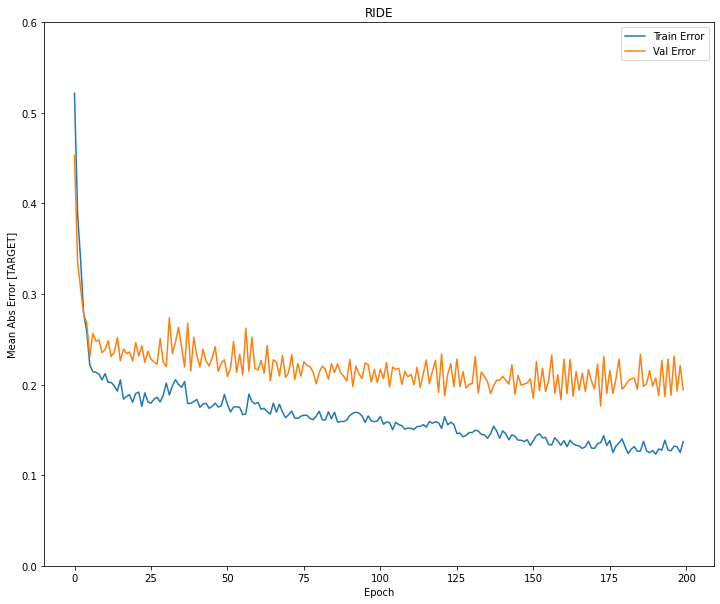

In [23]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [TARGET]')
  plt.title('RIDE')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,0.6])
  plt.legend()

  plt.show()


plot_history(baseline_history)

Training set

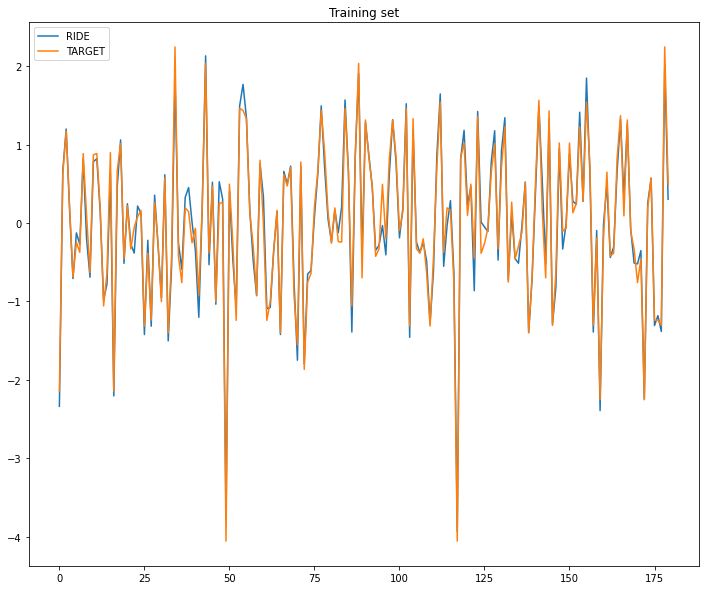

In [24]:
time_axis_train = range(0,train_labels.shape[0])
plt.title('Training set')
plt.plot(time_axis_train, model.predict(train_features).flatten(), label='RIDE') ### Training set
plt.plot(time_axis_train, train_labels, label='TARGET')
plt.legend()
plt.show()

In [25]:
model_train = model.predict(train_features)
Train_error = model_train.flatten() - train_labels
MAE_train_set = np.sum(np.abs(Train_error))/Train_error.shape
MAE_train_set


array([0.11935303])

Test set

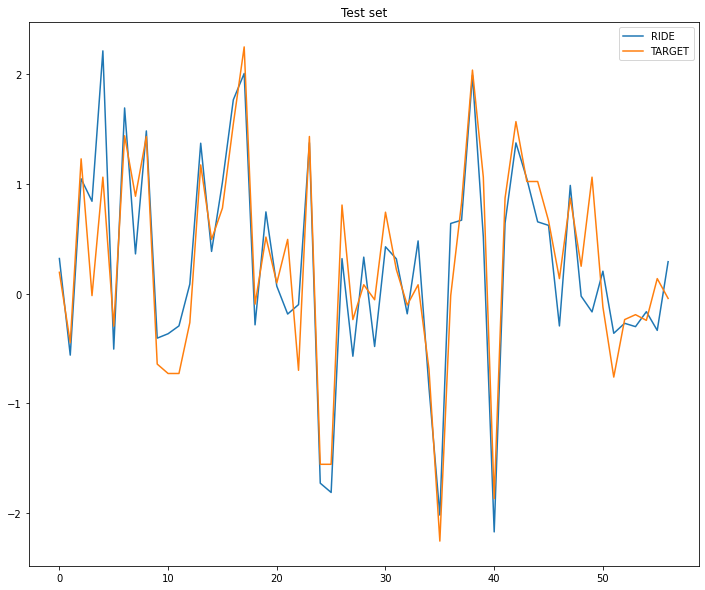

In [26]:
time_axis_test = range(0,test_labels.shape[0]) #Test set
RIDE_model = model.predict(test_features) # Test set
plt.title('Test set')
#plt.bar(time_axis_test, test_labels.T, width=1, linewidth=1, align='center', color="lightgray", label='GAP') 
plt.plot(time_axis_test, RIDE_model, label='RIDE')
plt.plot(time_axis_test, test_labels, label='TARGET')
plt.legend()
plt.show()

In [27]:
Test_error = RIDE_model.flatten() - test_labels
MAE_test_set = np.sum(np.abs(Test_error))/Test_error.shape
MAE_test_set

array([0.30195131])

All data

In [28]:
#All data
x = raw_data_log

#normalize
x_mean = x.mean()
x_std = x.std()
x = (x - x_mean) / x_std

#if the TARGET is not normalized.
#target_x = x.pop('GDP')

target_x = x.pop('TARGET')


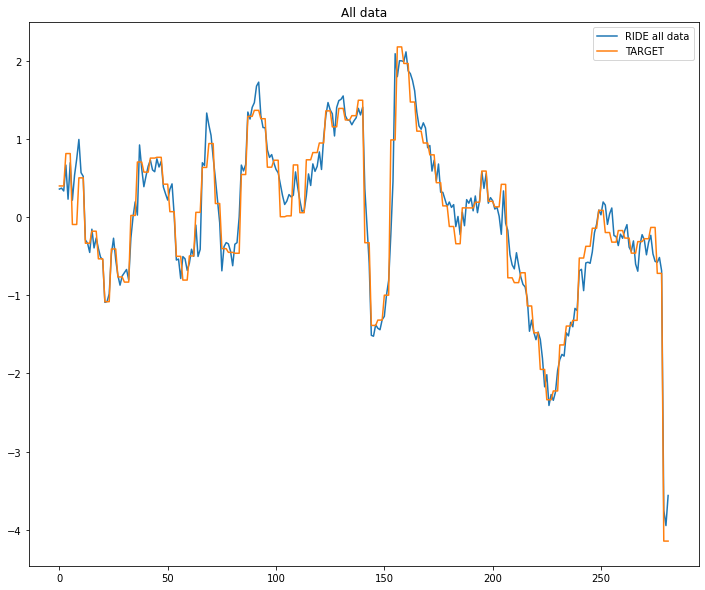

In [29]:
time_axis = range(0,raw_data_log.shape[0]) 
RIDE_model_all_data = model.predict(x) # All data
plt.title('All data') 
plt.plot(time_axis, RIDE_model_all_data, label='RIDE all data')
plt.plot(time_axis, target_x, label='TARGET')
plt.legend()
plt.show()

In [30]:
#export output to csv file
import datetime
now = datetime.datetime.now().strftime("%Y%m%d_%Hh%M")
a = np.asarray(RIDE_model_all_data)
np.savetxt("RIDE_model_all_data_"+now+".csv", a, delimiter=",")